In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn           as sns
import libraries.model   as clm
import libraries.dataset as cld
import os
import torch
import json

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

# Compute phase transitions

In [2]:
target_folder = 'model'

In [3]:
# Load the standardized dataset, with corresponding labels and parameters
train_dataset = torch.load(f'{target_folder}/train_dataset_std.pt', weights_only=False)
val_dataset   = torch.load(f'{target_folder}/val_dataset_std.pt', weights_only=False)
test_dataset  = torch.load(f'{target_folder}/test_dataset_std.pt', weights_only=False)

In [4]:
n_temperatures = sum([1 for graph in train_dataset if graph.label == train_dataset[0].label])
n_temperatures

7

In [5]:
# Load the data from the JSON file
with open(f'{target_folder}/standardized_parameters.json', 'r') as json_file:
    numpy_dict = json.load(json_file)

# Convert NumPy arrays back to PyTorch tensors
standardized_parameters = {}
for key, value in numpy_dict.items():
    try:
        standardized_parameters[key] = torch.tensor(value)
    except:
        standardized_parameters[key] = value

# Load Graph Neural Network model (making room for temperature as node attribute) to device
# Dropout for initializing the model, not used at all while predicting
model = clm.GCNN(features_channels=train_dataset[0].num_node_features,
             pdropout=0).to(device)

# Load and evaluate Graph Neural Network model
model.load_state_dict(torch.load(f'{target_folder}/model.pt', map_location=torch.device(device)))
model.eval()

GCNN(
  (conv1): GraphConv(5, 512)
  (conv2): GraphConv(512, 512)
  (linconv1): Linear(in_features=512, out_features=64, bias=True)
  (linconv2): Linear(in_features=64, out_features=16, bias=True)
  (lin): Linear(in_features=16, out_features=1, bias=True)
)

In [6]:
target_mean = standardized_parameters['target_mean']
scale       = standardized_parameters['scale']
target_std  = standardized_parameters['target_std']

In [7]:
reference_dataset = train_dataset
prediction_dataset_val = val_dataset
prediction_dataset_test = test_dataset

In [8]:
for data in reference_dataset:
    data.label = f'{data.label} {float(data.y)}'

In [9]:
uncertainty_data = cld.load_json(f'{target_folder}/uncertainty_data.json')

interpolator = clm.fit_interpolator(uncertainty_data['uncertainty_values'], reference_dataset, model)
del reference_dataset

In [10]:
# Compute predictions and corresponding uncertainties

## Validation
predictions_val,  uncertainties_val  = clm.make_predictions(prediction_dataset_val, model, standardized_parameters,
                                                           uncertainty_data, interpolator)

n_graphs = int(len(predictions_val) / n_temperatures)
uncertainties_list = []
for i in range(n_graphs):
    idx0 = i     * n_temperatures
    idxf = (i+1) * n_temperatures

    # Concatenate array
    uncert = uncertainties_val[idx0:idxf]
    uncert = np.ones_like(uncert) * np.max(np.abs(uncert))
    uncertainties_list.append(uncert)
uncertainties_val = np.concatenate(uncertainties_list)

## Test
predictions_test, uncertainties_test = clm.make_predictions(prediction_dataset_test, model, standardized_parameters,
                                                           uncertainty_data, interpolator)

n_graphs = int(len(predictions_test) / n_temperatures)
uncertainties_list = []
for i in range(n_graphs):
    idx0 = i     * n_temperatures
    idxf = (i+1) * n_temperatures

    # Concatenate array
    uncert = uncertainties_test[idx0:idxf]
    uncert = np.ones_like(uncert) * np.max(np.abs(uncert))
    uncertainties_list.append(uncert)
uncertainties_test = np.concatenate(uncertainties_list)

In [11]:
ground_truths_val = []
for i, data in enumerate(prediction_dataset_val):
    ground_truth = data.y * target_std / scale + target_mean
    ground_truths_val.append(float(ground_truth.cpu().numpy()[0]))

ground_truths_test = []
for i, data in enumerate(prediction_dataset_test):
    ground_truth = data.y * target_std / scale + target_mean
    ground_truths_test.append(float(ground_truth.cpu().numpy()[0]))

In [12]:
temperature_std = -7.8404  # -7.8404 * 25.5088 / scale + 500.0000 gives 300K

predictions_val_aux = []
uncertainties_val_aux = []
ground_truths_val_aux = []
for idx, data in enumerate(val_dataset):
    if np.abs(data.x[0][-1].cpu().numpy() - temperature_std) < 0.5:
        predictions_val_aux.append(predictions_val[idx])
        uncertainties_val_aux.append(uncertainties_val[idx])
        ground_truths_val_aux.append(ground_truths_val[idx])
predictions_val = np.array(predictions_val_aux)
uncertainties_val = np.array(uncertainties_val_aux)
ground_truths_val = np.array(ground_truths_val_aux)

predictions_test_aux = []
uncertainties_test_aux = []
ground_truths_test_aux = []
for idx, data in enumerate(test_dataset):
    if np.abs(data.x[0][-1].cpu().numpy() - temperature_std) < 0.5:
        predictions_test_aux.append(predictions_test[idx])
        uncertainties_test_aux.append(uncertainties_test[idx])
        ground_truths_test_aux.append(ground_truths_test[idx])
predictions_test = np.array(predictions_test_aux)
uncertainties_test = np.array(uncertainties_test_aux)
ground_truths_test = np.array(ground_truths_test_aux)

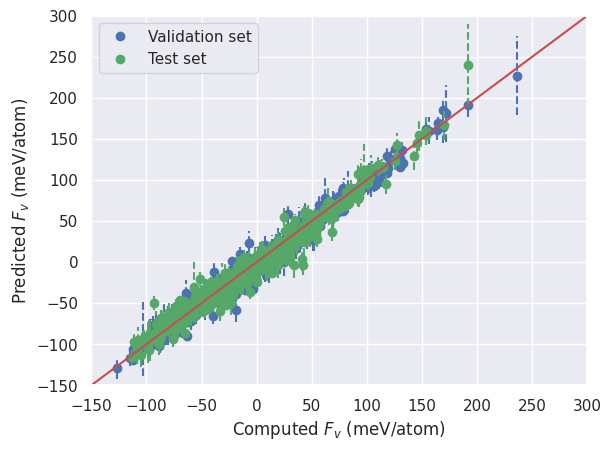

In [13]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.plot(ground_truths_val, predictions_val, 'o', color=colors[0], label='Validation set')
for x, y, err in zip(ground_truths_val, predictions_val, uncertainties_val):
    plt.plot([x, x], [y - err, y + err], '--', color=colors[0])

plt.plot(ground_truths_test, predictions_test, 'o', color=colors[2], label='Test set')
for x, y, err in zip(ground_truths_test, predictions_test, uncertainties_test):
    plt.plot([x, x], [y - err, y + err], '--', color=colors[2])

_min_ = np.min([np.min(ground_truths_val), np.min(predictions_val-uncertainties_val)])
_max_ = np.max([np.max(ground_truths_val), np.max(predictions_val+uncertainties_val)])
_min_ = -150
_max_ =  300
plt.plot([_min_, _max_], [_min_, _max_], '-r')  # Identity line
plt.xlabel('Computed $F_v$ (meV/atom)')
plt.ylabel('Predicted $F_v$ (meV/atom)')
plt.legend(loc='best')
plt.xlim(_min_, _max_)
plt.ylim(_min_, _max_)
plt.savefig('UQ-prediction-comparison.pdf', dpi=50, bbox_inches='tight')
plt.show()

In [14]:
diff_real_val = np.abs(predictions_val - ground_truths_val)
diff_predictions_val = uncertainties_val

diff_real_test = np.abs(predictions_test - ground_truths_test)
diff_predictions_test = uncertainties_test

diff_real      = np.concatenate([diff_real_val,        diff_real_test])
diff_predicted = np.concatenate([diff_predictions_val, diff_predictions_test])

mask = (diff_real < 24.9) & (diff_predicted < 24.9)
diff_real      = diff_real[mask]
diff_predicted = diff_predicted[mask]

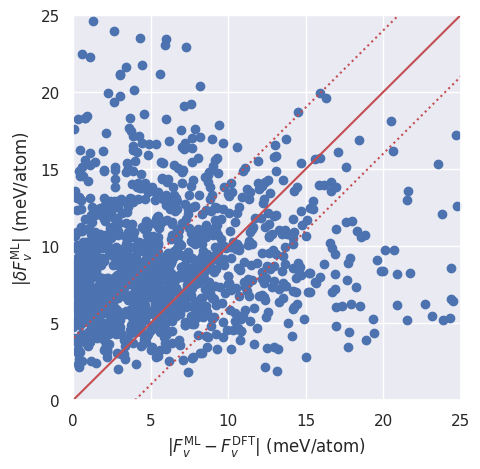

In [19]:
fig = plt.figure(figsize=(5, 5))

plt.plot(diff_real, diff_predicted, 'o')

_min_ = 0
_max_ = 25

plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.plot([_min_-4, _max_-4], [_min_, _max_], ':r')
plt.plot([_min_+4, _max_+4], [_min_, _max_], ':r')
plt.xlabel(r"$|F_v^{\text{ML}} - F_v^{\text{DFT}}|$ (meV/atom)")
plt.ylabel(r"$|\delta F_v^{\text{ML}}|$ (meV/atom)")
plt.xlim(_min_, _max_)
plt.ylim(_min_, _max_)
plt.savefig('UQ-diff-comparison.pdf', dpi=50, bbox_inches='tight')
plt.show()